#### Generalizing the VMC to arbitrary number of parameters
This now takes in a wavefunction with an arbitrary number of parameters, and then instead of 
generating a plot to find the minimum average energy, it uses the gradient descent algorithm
to find the minimum. 

In [33]:
import numpy as np
from matplotlib import pyplot as plt
import random
from scipy import integrate, optimize
import sympy as sym

m = 1
omega = 1
lam = 0
hbar = 1
num_samples = 10**3

# define all the symbolic variables and expressions
x = sym.Symbol('x')
a = sym.Symbol('a')
b = sym.Symbol('b')
c = sym.Symbol('c')
d = sym.Symbol('d')
f = sym.Symbol('f')
g = sym.Symbol('g')

# sym_psi = a*sym.exp(-b*(x+c)**2)+ d*sym.exp(f*(x+g)**2)
# sym_ddpsi = sym.diff(sym.diff(sym_psi, x), x)
# sym_a = sym.diff(sym.log(sym_psi), a)
# sym_b = sym.diff(sym.log(sym_psi), b)
# sym_c = sym.diff(sym.log(sym_psi), c)
# sym_d = sym.diff(sym.log(sym_psi), d)
# sym_f = sym.diff(sym.log(sym_psi), f)
# sym_g = sym.diff(sym.log(sym_psi), g)

sym_psi = a*sym.exp(-b*(x)**2)
sym_ddpsi = sym.diff(sym.diff(sym_psi, x), x)
sym_a = sym.diff(sym.log(sym_psi), a)
sym_b = sym.diff(sym.log(sym_psi), b)
sym_c = sym.diff(sym.log(sym_psi), c)
# sym_d = sym.diff(sym.log(sym_psi), d)
# sym_f = sym.diff(sym.log(sym_psi), f)
# sym_g = sym.diff(sym.log(sym_psi), g)



# define the potential
def V(x_inp):
    return 1/2 * m * omega**2 * x_inp**2 + lam * x_inp**4
# define the wavefunction
def psi(x_inp, params):

    return sym_psi.subs([(x, x_inp), (a, params[0]), (b, params[1])]).evalf()
    return sym_psi.subs([(x, x_inp), (a, params[0]), (b, params[1]), (c, params[2]), (d, params[3]), (f, params[4]), (g, params[5])]).evalf()

# define the second derivative w.r.t x of the wavefunction
def ddpsi(x_inp, params):
    return sym_ddpsi.subs([(x, x_inp), (a, params[0]), (b, params[1])]).evalf()
    return sym_ddpsi.subs([(x, x_inp), (a, params[0]), (b, params[1]), (c, params[2]), (d, params[3]), (f, params[4]), (g, params[5])]).evalf()

# returns the gradient of the log of psi
def grad_log_psi(x_inp, params):
    # this will return a vector of length len(params)
    grad = np.zeros(len(params))
    # now add in the derivatives with respect to each variable
    # subs_vec = [(x, x_inp), (a, params[0]), (b, params[1]), (c, params[2]), (d, params[3]), (f, params[4]), (g, params[5])]
    subs_vec = [(x, x_inp), (a, params[0]), (b, params[1])]
    grad[0] = sym_a.subs(subs_vec).evalf()
    grad[1] = sym_b.subs(subs_vec).evalf()
    # grad[2] = sym_c.subs(subs_vec).evalf()
    # grad[3] = sym_d.subs(subs_vec).evalf()
    # grad[4] = sym_f.subs(subs_vec).evalf()
    # grad[5] = sym_g.subs(subs_vec).evalf()
    return grad


# define the Hamiltonian applied to psi
def Hpsi(x_inp, params):
    return V(x_inp)*psi(x_inp,params) - hbar**2/(2*m) * ddpsi(x_inp, params)

# define the probability density to be sampling
def p(x, params):
    return psi(x,params)**2/integrate.quad(psi, -np.inf, np.inf,args=params)[0]

# define the function that samples the probability distribution
# uses the metropolis sampling method
def sample(params, num_samples):
    print("sampling...")
    outputs = []
    # pick the start point
    x_t = 0
    for t in range(num_samples):
        x_prime = x_t + random.uniform(-1,1)
        
        if (random.uniform(0,1) < psi(x_t, params)**2/psi(x_prime, params)**2):
            x_t = x_prime
        outputs.append(x_t)
    print("done sampling.")
    return outputs

# define a function that computes the average energy
def avg_energy(params, N):
    # get N sampled points
    samples = sample(params, N)
    # apply the function to every point
    applied = [(1/psi(x_a, params) * Hpsi(x_a, params)) for x_a in samples]
    return 1/N * sum(applied)

# def avg_gradient_log_psi(params, N):
#     # get N sampled points
#     samples = sample(params, N)
#     # apply the function to every point
#     applied = [grad_log_psi(x_a, params) for x_a in samples]
#     return 1/N * sum(applied)

# def avg_both(params, N):
#     # get N sampled points
#     samples = sample(params, N)
#     # apply the function to every point
#     applied = [(1/psi(x_a,params) * grad_log_psi(x_a, params) * Hpsi(x_a, params)) for x_a in samples]
#     return 1/N * sum(applied)

def gradient(params, N):
    samples = sample(params, N)
    #print("computing gradient using samples...")
    # now compute the 3 different averages
    print("Computing Energy")
    energy_exp = 1/N * sum([(1/psi(x_a, params) * Hpsi(x_a, params)) for x_a in samples])
    print("Computing Gradient of Log psi")
    gradlogpsi_exp = 1/N * sum([grad_log_psi(x_a, params) for x_a in samples])
    print("Computing Mixed Term")
    both_exp = 1/N * sum([(1/psi(x_a, params) * grad_log_psi(x_a, params) * Hpsi(x_a, params)) for x_a in samples])
    return (2 * both_exp - 2 * energy_exp * gradlogpsi_exp)

# write a gradient descent optimizer for the average energy
def grad_opt(start_params, learning_rate, max_iterations=100, tolerance=.01, N=10**4):
    # pick the starting position
    params = start_params
    # iterate until we run out of iterations or less than tolerance
    for it in range(max_iterations):
        print("Iteration " + str(it))
        # compute the gradient at that point
        diff = learning_rate * gradient(params, N)
        if all(abs(val) < tolerance for val in diff):
            print("All under tolerance")
            return params
        # if one of the terms gets to big
        if any(abs(val) > 10**10 for val in diff):
            print("Gradient element too large")
            return params
        # make a step in the direction opposite the gradient
        params = params - diff
        print("diff: " + str(diff))
        print("params: " + str(params))
    return params

In [34]:
start = [1,.5,1,1,.1,.1]
start2 = [1,.4]
optd = grad_opt(start2, .1, N=10**3)
print(optd)

Iteration 0
sampling...
done sampling.
Computing Energy
Computing Gradient of Log psi
Computing Mixed Term
diff: [0 -12113845.6680056]
params: [1.00000000000000 12113846.0680056]
Iteration 1
sampling...
done sampling.
Computing Energy
Computing Gradient of Log psi
Computing Mixed Term
Gradient element too large
[1.00000000000000 12113846.0680056]


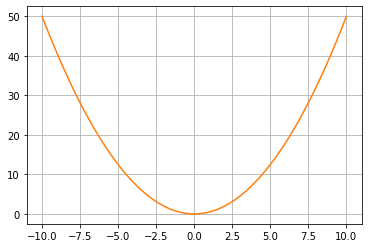

In [24]:
#plot the wavefunction

x_vals = np.linspace(-10,10,100)
y = [psi(x_a, optd) for x_a in x_vals]
v = [V(x_a) for x_a in x_vals]

plt.plot(x_vals,y)
plt.plot(x_vals,v)
plt.grid()
plt.show()